## Classification of Car Evaluation

Car Evaluation Dataset: http://archive.ics.uci.edu/dataset/19/car+evaluation

### 1. Import and clean dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [2]:
headers = ["Buying", "Maintenance", "Doors", "Capacity", "Trunk Size", "Safety", "Evaluation"]
data = pd.read_csv('./datasets/car.data', header = None, names = headers)
data.head()

,Buying,Maintenance,Doors,Capacity,Trunk Size,Safety,Evaluation
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [3]:
print(data.dtypes)

Buying         object
Maintenance    object
Doors          object
Capacity       object
Trunk Size     object
Safety         object
Evaluation     object
dtype: object


In [4]:
print(data.isnull().sum().sum())

0


In [5]:
print(data['Evaluation'].value_counts())

Evaluation
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64


In [6]:
le = LabelEncoder()
data["Buying"] = le.fit_transform(data["Buying"])
data["Maintenance"] = le.fit_transform(data["Maintenance"])
data["Doors"] = le.fit_transform(data["Doors"])
data["Capacity"] = le.fit_transform(data["Capacity"])
data["Trunk Size"] = le.fit_transform(data["Trunk Size"])
data["Safety"] = le.fit_transform(data["Safety"])
data["Evaluation"] = le.fit_transform(data["Evaluation"])
data.head()

,Buying,Maintenance,Doors,Capacity,Trunk Size,Safety,Evaluation
0,3,3,0,0,2,1,2
1,3,3,0,0,2,2,2
2,3,3,0,0,2,0,2
3,3,3,0,0,1,1,2
4,3,3,0,0,1,2,2


In [7]:
print(data['Evaluation'].value_counts())

Evaluation
2    1210
0     384
1      69
3      65
Name: count, dtype: int64


In [8]:
data = data.to_numpy()

data[data[:,6] == 0,6] = 1
data[data[:,6] == 1,6] = 1 
data[data[:,6] == 3,6] = 1
data[data[:,6] == 2,6] = 0

print(data[0:5,:])

[[3 3 0 0 2 1 0]
 [3 3 0 0 2 2 0]
 [3 3 0 0 2 0 0]
 [3 3 0 0 1 1 0]
 [3 3 0 0 1 2 0]]


### 2. Define visualization functions

In [9]:
def draw_heatmap(acc, acc_desc, C_list, character):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=C_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(ylabel='$'  + character + '$')
    plt.title(acc_desc + ' w.r.t $' + character + '$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()

In [10]:
def draw_curve(acc, acc_desc, C_list, character):
    plt.figure()
    plt.plot(range(len(C_list)), acc, label=acc_desc)
    plt.xticks(range(len(C_list)),labels=C_list)
    plt.xlabel(character)
    plt.ylabel('Accuracy')
    plt.title(acc_desc + ' w.r.t $' + character + '$')
    plt.legend()
    plt.show()

### 3. Classification

In [11]:
avg_test_acc_result = np.zeros((3,3))
best_train_result = np.zeros((3,3))
best_param_result = np.zeros((3,3))

### 3.1 Using Logistic Regression Classifier

In [12]:
def logReg_classifier():
    classifier = LogisticRegression(random_state=0)
    C_list = [10**-8, 10**-7, 10**-6,10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 1, 10, 10**2, 10**3, 10**4]
    paramaters = {'C': C_list}
    clf = GridSearchCV(classifier, paramaters, return_train_score = True, cv = 5)
    clf.fit(X_train, Y_train)

    train_acc = clf.cv_results_['mean_train_score']
    draw_heatmap(train_acc.reshape(-1,1), 'LR train accuracy', C_list, 'C')
    draw_curve(train_acc.reshape(-1,1), 'LR train accuracy', C_list, 'C')

    val_acc = clf.cv_results_['mean_test_score']
    draw_heatmap(val_acc.reshape(-1,1), 'LR val accuracy', C_list, 'C')
    draw_curve(val_acc.reshape(-1,1), 'LR val accuracy', C_list, 'C')
    
    opt_classifier = LogisticRegression(random_state=0, C = clf.best_params_['C'])
    
    for i,j in enumerate(C_list):
        if j == clf.best_params_['C']:
            best_train_acc = train_acc[i]

    opt_classifier.fit(X_train, Y_train)
    test_acc = opt_classifier.score(X_test, Y_test)
    return test_acc, best_train_acc, clf.best_params_['C']

Partition:  0.8


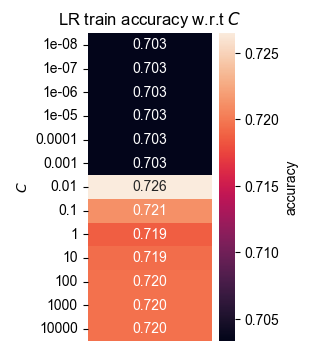

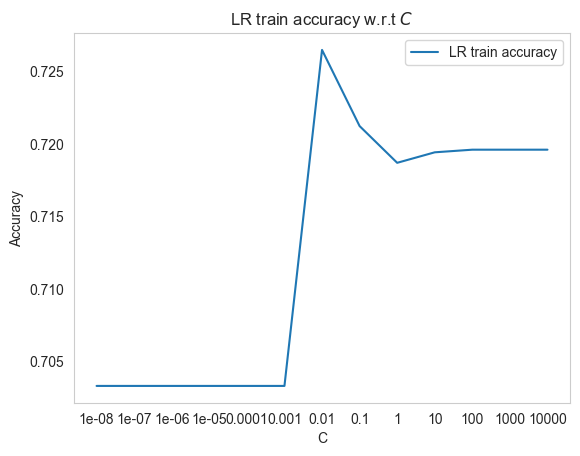

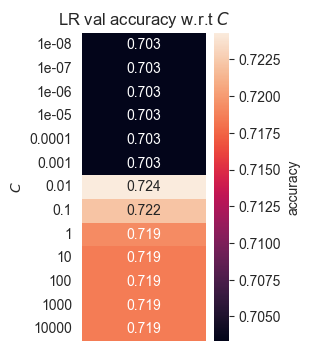

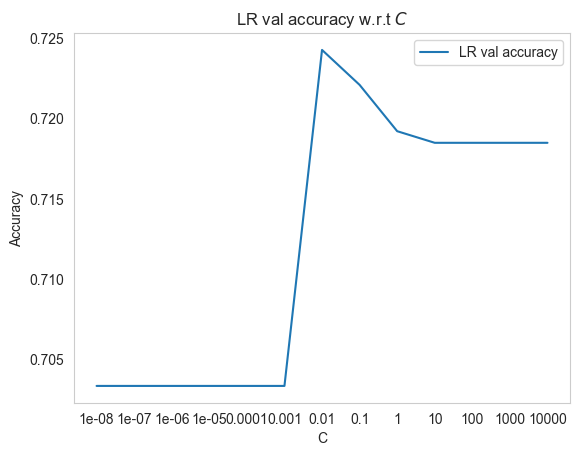

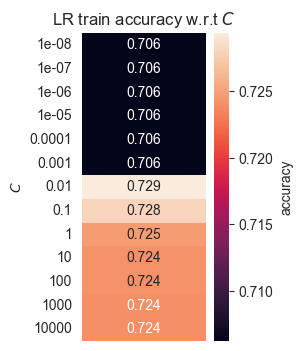

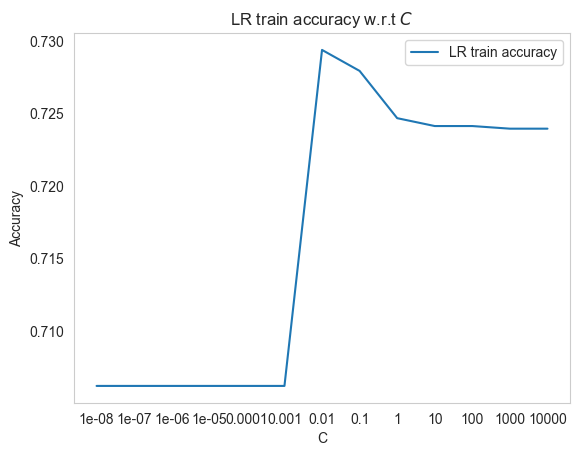

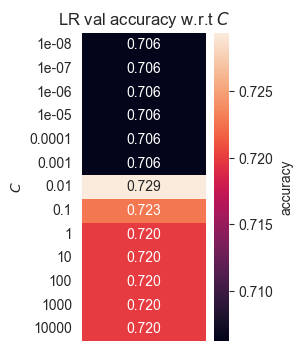

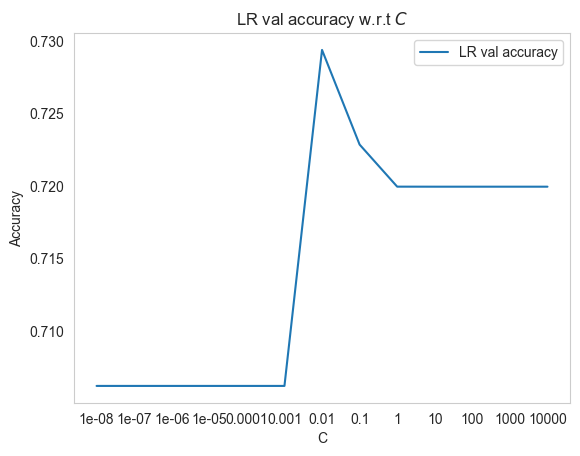

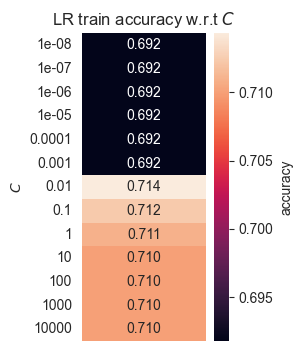

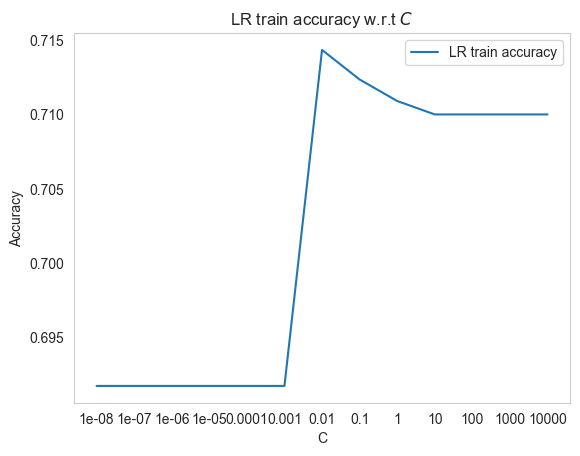

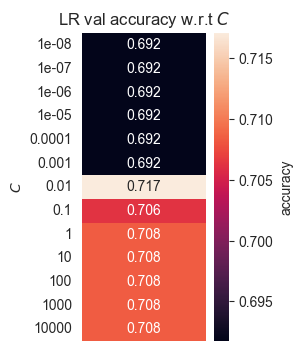

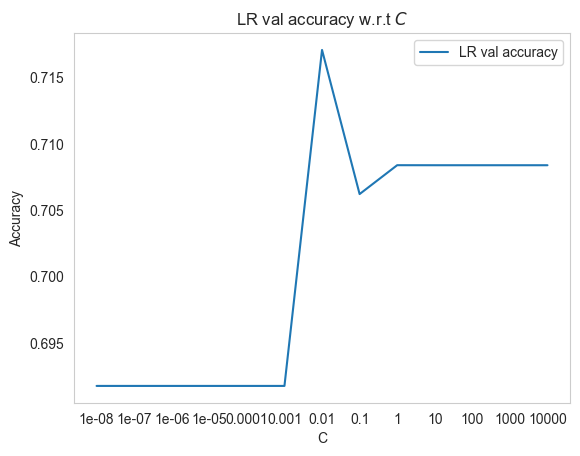

Test Accuracy Average Over 3 Trials for Logistic Regression =  0.7254335260115607
Partition:  0.5


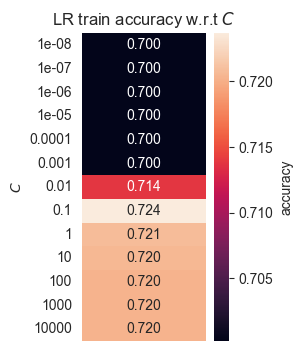

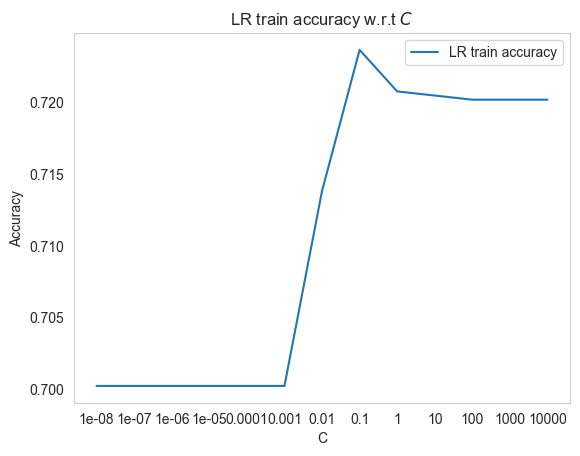

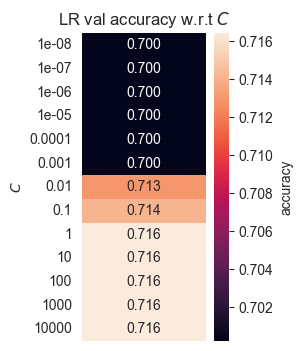

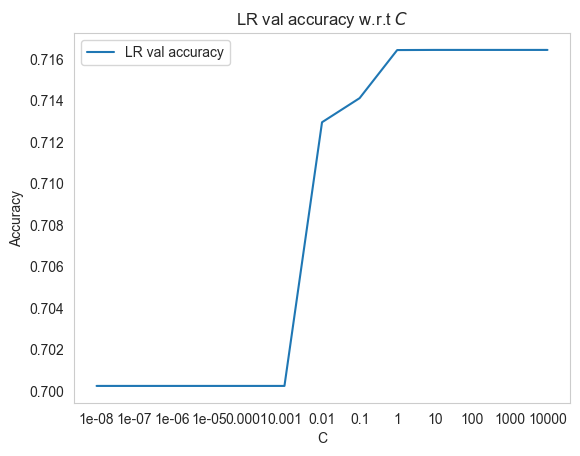

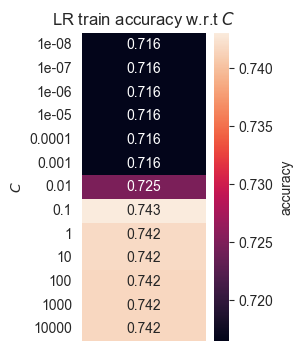

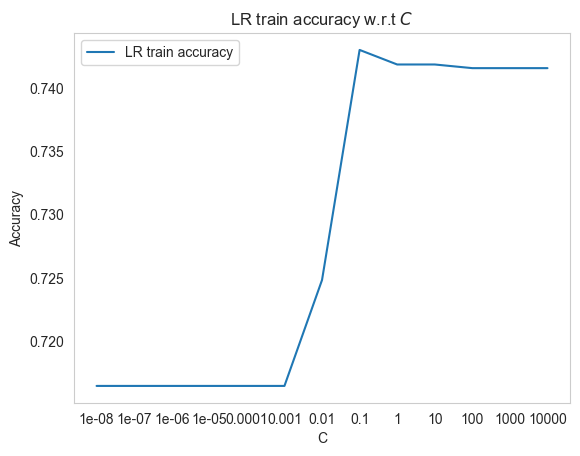

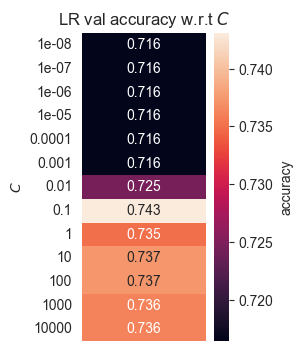

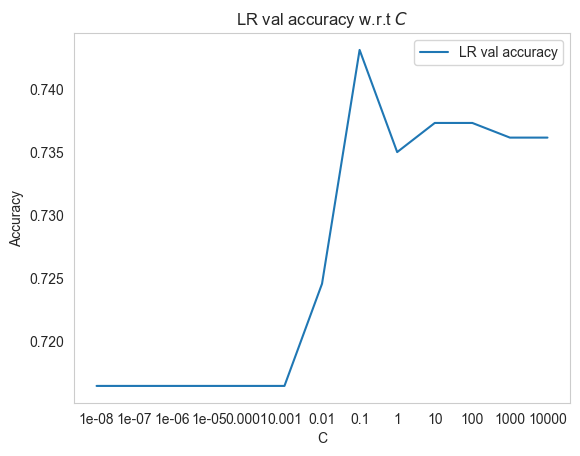

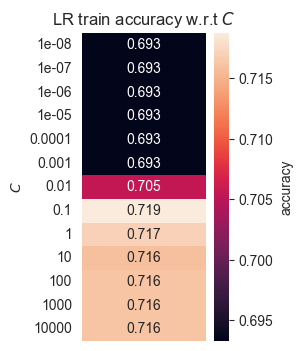

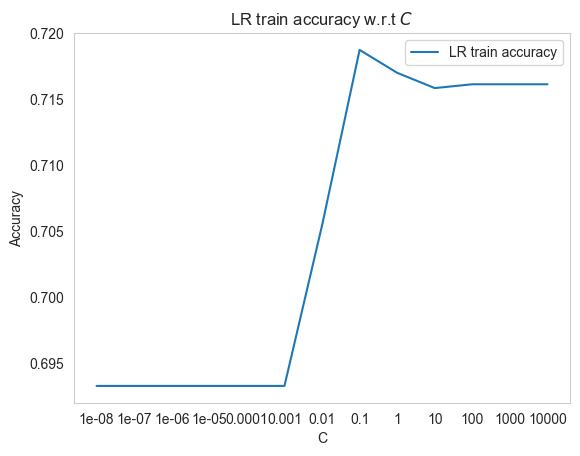

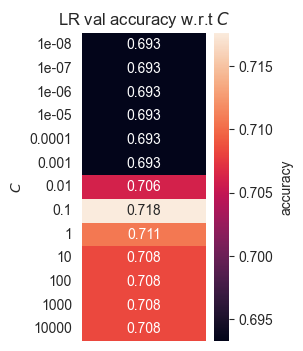

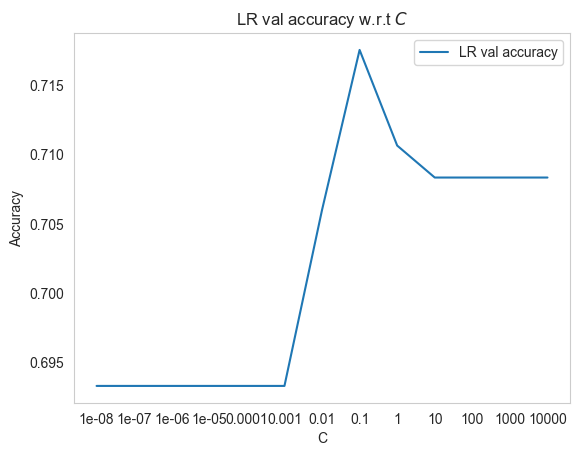

Test Accuracy Average Over 3 Trials for Logistic Regression =  0.7106481481481483
Partition:  0.2


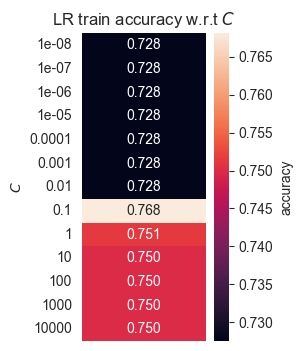

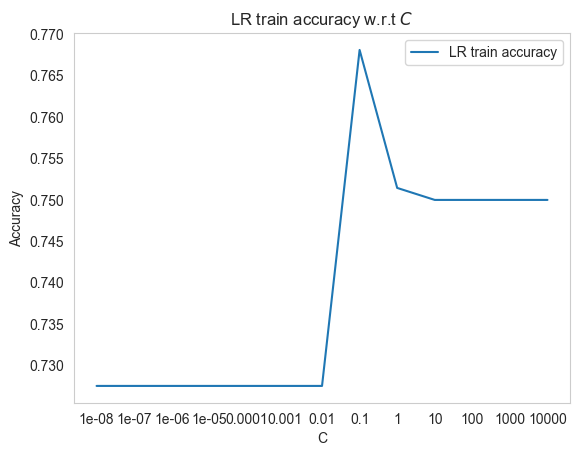

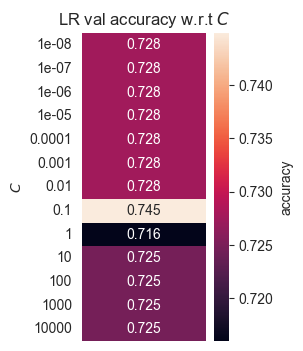

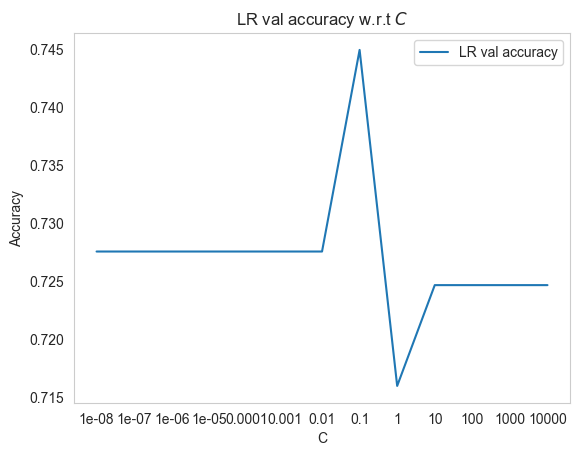

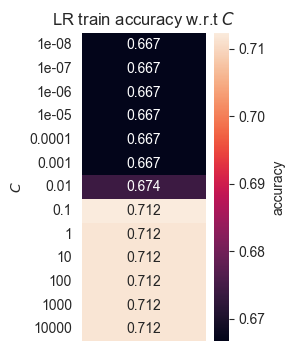

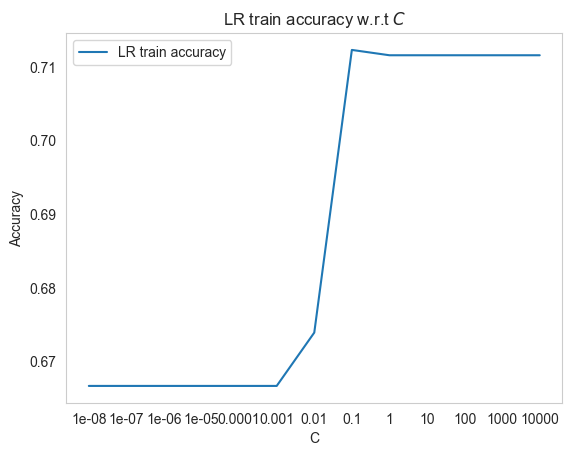

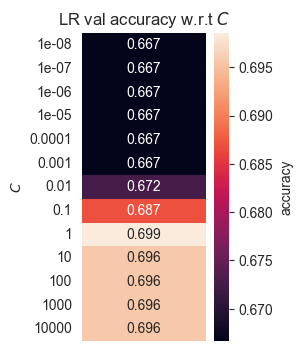

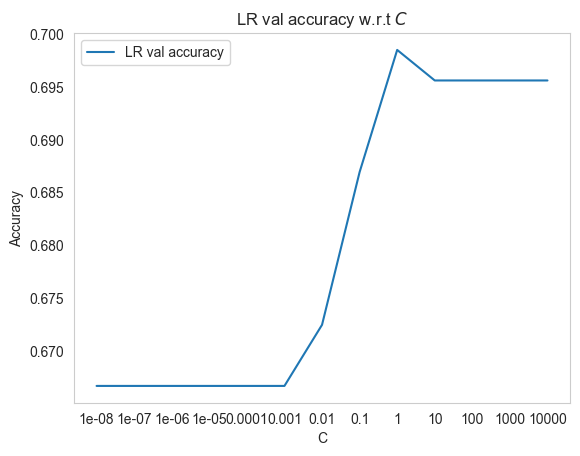

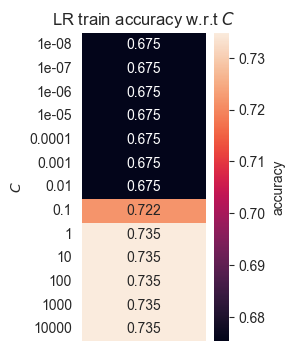

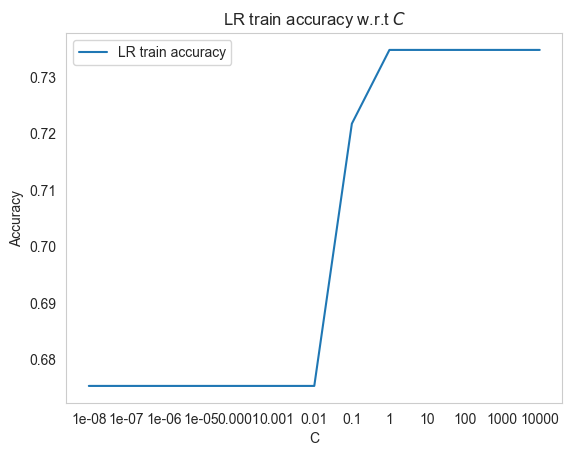

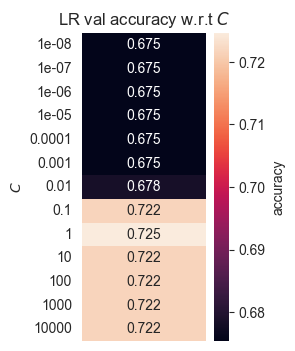

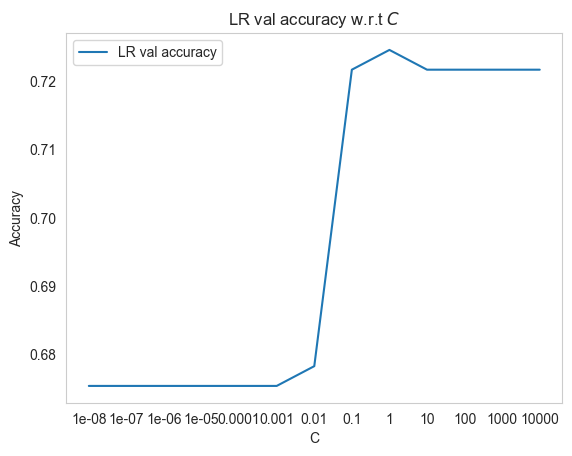

Test Accuracy Average Over 3 Trials for Logistic Regression =  0.7208966015907446


In [13]:
partition_val = [0.8, 0.5, 0.2]
for i, partition in enumerate(partition_val):
    print("Partition: ", partition)
    logReg_test_acc = []

    for trial in range(3):
        np.random.shuffle(data)
        X_train = data[:int(partition*len(data)), :6]
        Y_train = data[:int(partition*len(data)), 6]
        X_test = data[int(partition*len(data)):, :6]
        Y_test = data[int(partition*len(data)):, 6]

        test_acc, best_train, c = logReg_classifier()
        logReg_test_acc.append(test_acc)
        
    avg_test_acc = sum(logReg_test_acc)/3
    avg_test_acc_result[i, 0] = avg_test_acc
    best_train_result[i, 0] = best_train
    best_param_result[i, 0] = c
    
    print("Test Accuracy Average Over 3 Trials for Logistic Regression = ", avg_test_acc)

### 3.2 Using SVM Classifier

In [14]:
def svm_classifier():
    classifier = svm.SVC(kernel = 'linear')
    C_list     = [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 1, 10,] 
    parameters = {'C': C_list}
    clf = GridSearchCV(classifier, parameters, return_train_score = True, cv=5)
    clf.fit(X_train, Y_train)

    train_acc = clf.cv_results_['mean_train_score']
    draw_heatmap(train_acc.reshape(-1,1), 'SVM train accuracy', C_list, 'C')
    draw_curve(train_acc.reshape(-1,1), 'SVM train accuracy', C_list, 'C')

    val_acc = clf.cv_results_['mean_test_score']
    draw_heatmap(val_acc.reshape(-1,1), 'SVM val accuracy', C_list, 'C')
    draw_curve(val_acc.reshape(-1,1), 'SVM val accuracy', C_list, 'C')

    opt_classifier = svm.SVC(kernel = 'linear', C = clf.best_params_['C'] )
    
    for i,j in enumerate(C_list):
        if j == clf.best_params_['C']:
            best_train_acc = train_acc[i]
            
    opt_classifier.fit(X_train, Y_train)
    test_acc = opt_classifier.score(X_test, Y_test)
    return test_acc, best_train_acc, clf.best_params_['C']

Partition:  0.8


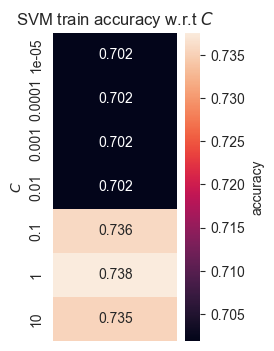

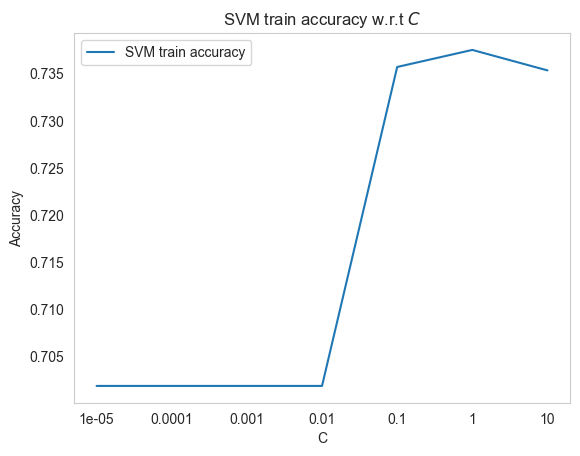

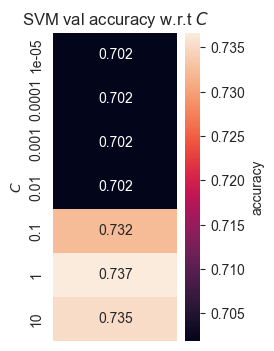

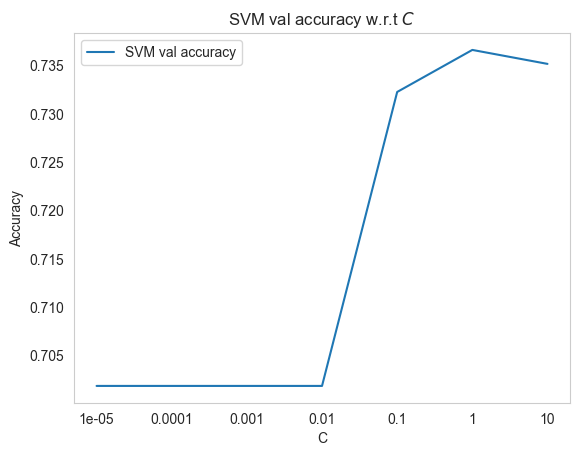

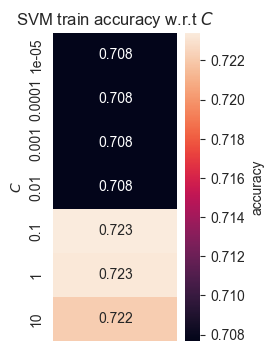

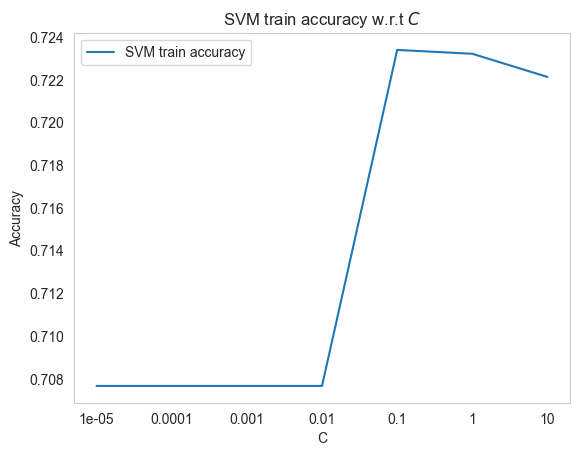

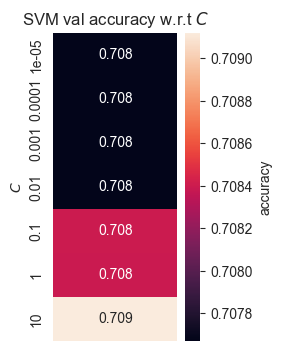

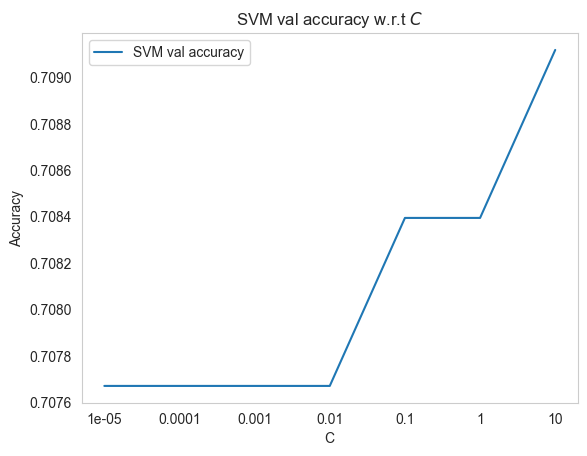

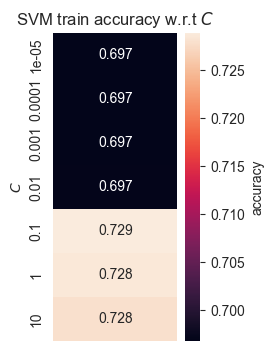

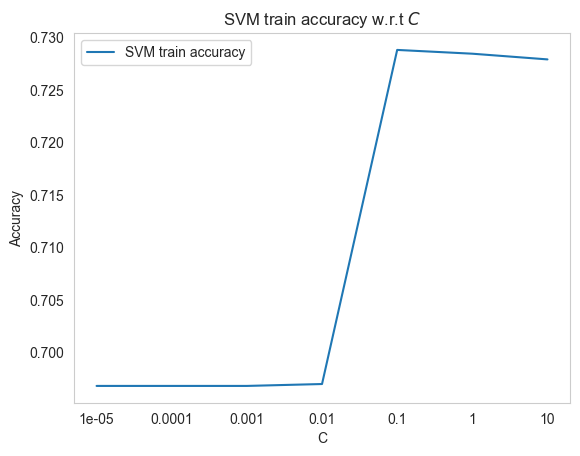

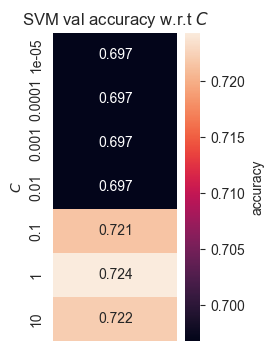

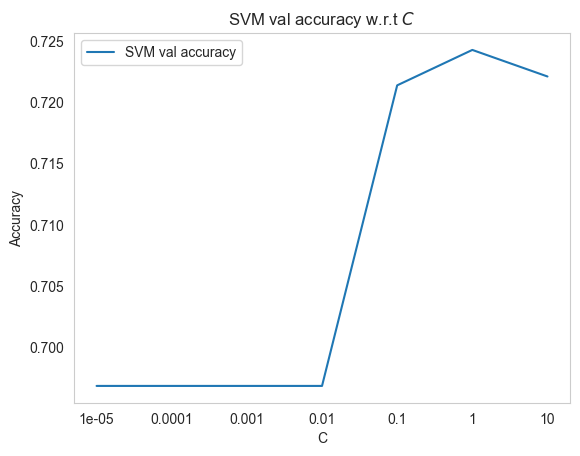

Test Accuracy Average Over 3 Trials for SVM =  0.720616570327553
Partition:  0.5


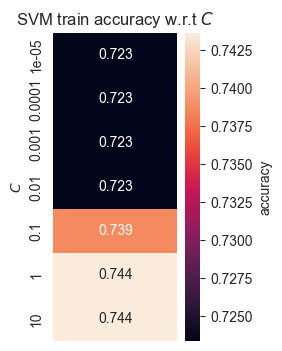

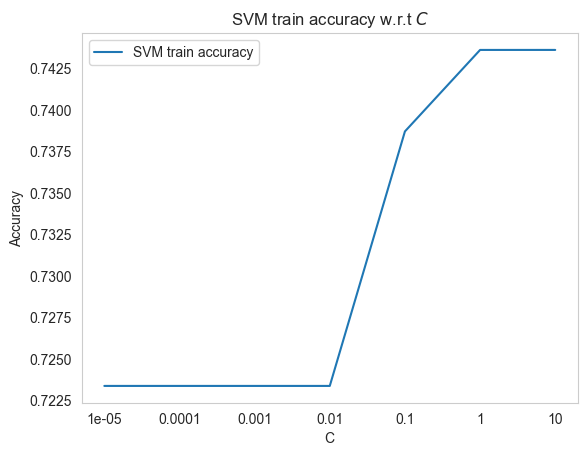

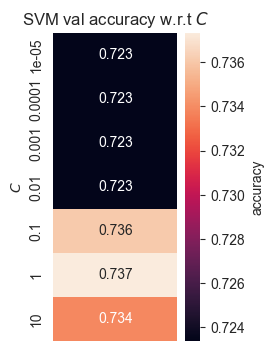

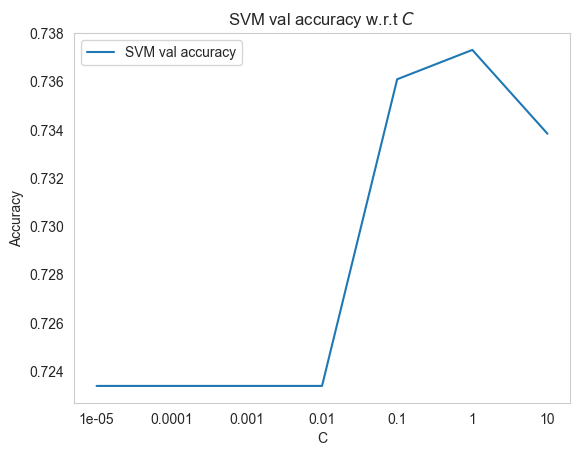

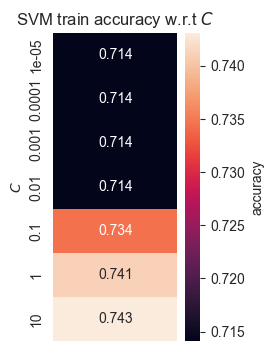

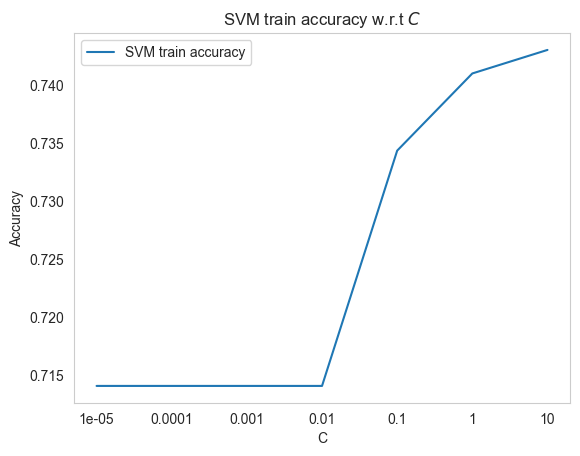

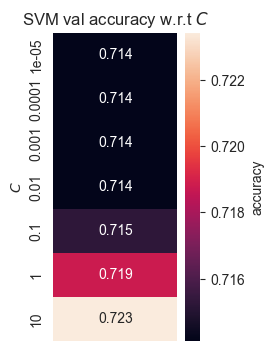

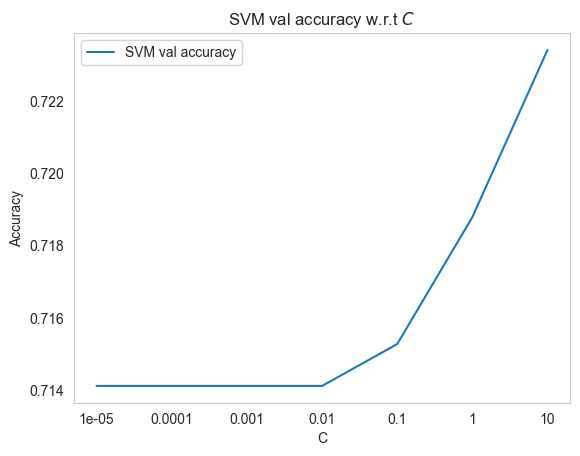

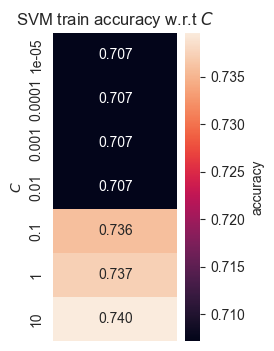

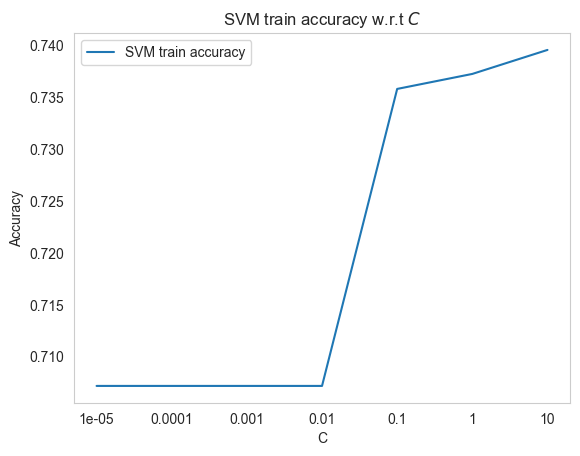

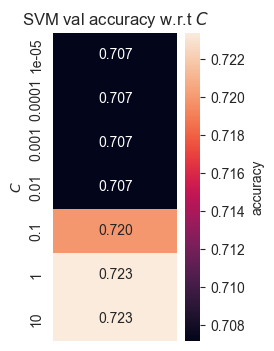

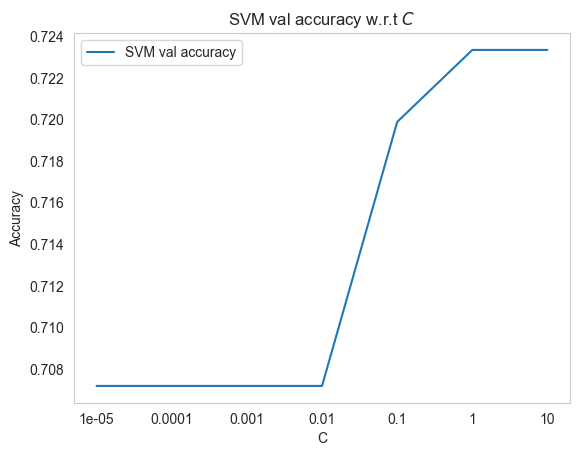

Test Accuracy Average Over 3 Trials for SVM =  0.7106481481481483
Partition:  0.2


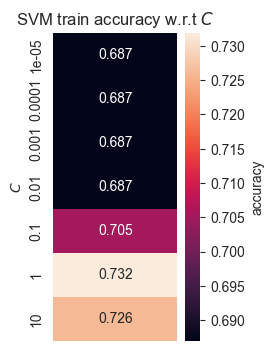

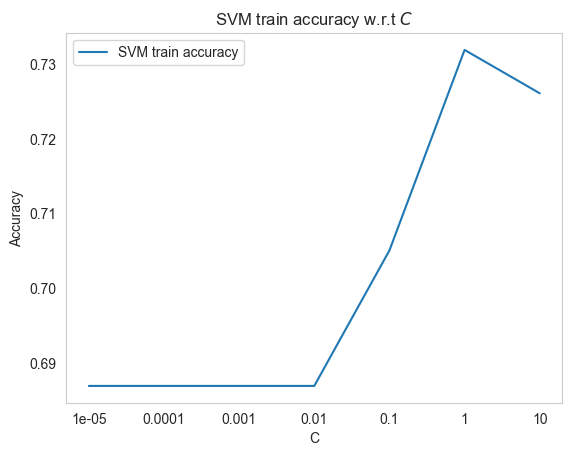

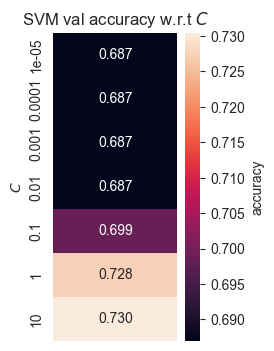

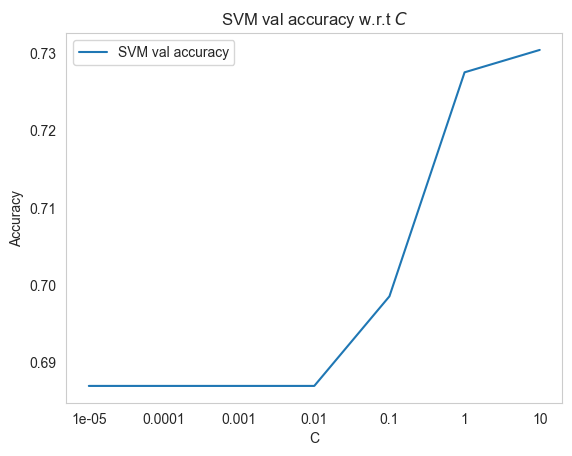

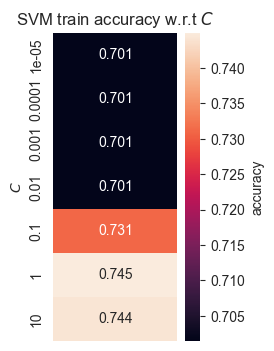

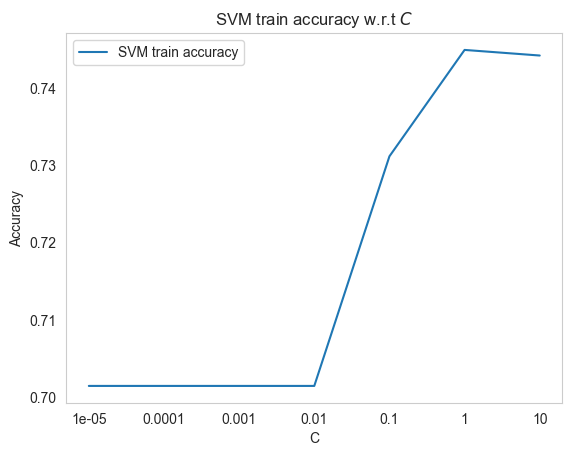

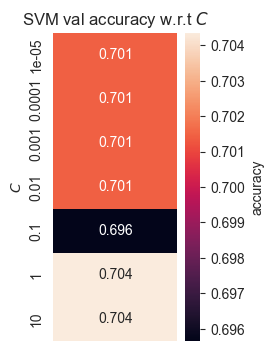

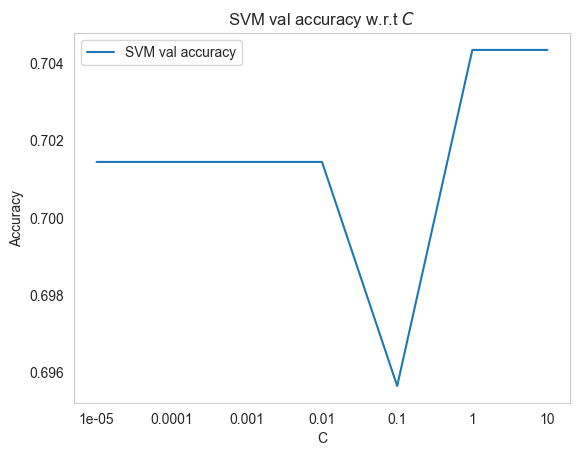

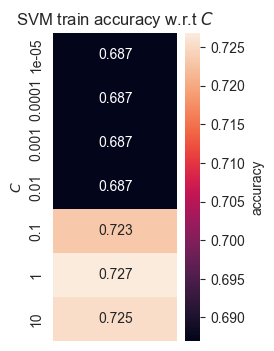

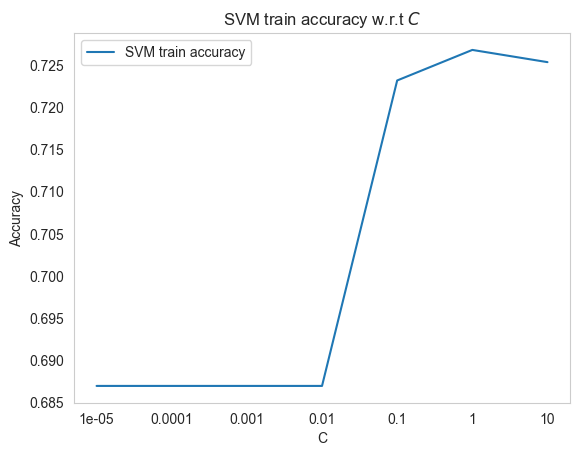

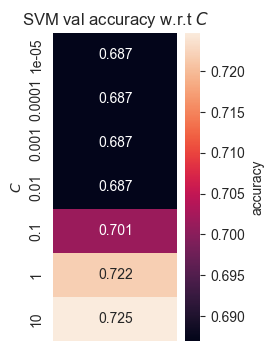

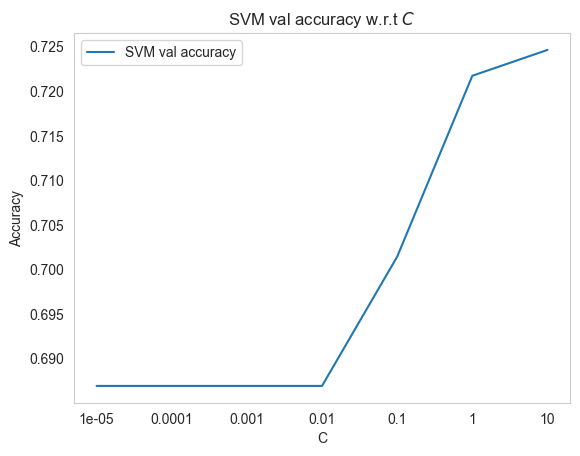

Test Accuracy Average Over 3 Trials for SVM =  0.7225837551217161


In [15]:
partition_val = [0.8, 0.5, 0.2]
for i, partition in enumerate(partition_val):
    print("Partition: ", partition)
    svm_test_acc = []

    for trial in range(3):
        np.random.shuffle(data)
        X_train = data[:int(partition*len(data)), :6]
        Y_train = data[:int(partition*len(data)), 6]
        X_test = data[int(partition*len(data)):, :6]
        Y_test = data[int(partition*len(data)):, 6]

        test_acc, best_train, c = svm_classifier()
        svm_test_acc.append(test_acc)
        
    avg_test_acc = sum(svm_test_acc)/3
    avg_test_acc_result[i, 1] = avg_test_acc
    best_train_result[i, 1] = best_train
    best_param_result[i, 1] = c
    
    print("Test Accuracy Average Over 3 Trials for SVM = ", avg_test_acc)

### 3.3 Using KNN Classifier

In [16]:
def knn_classifier():
    k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    parameters = {'n_neighbors':k_list}
    classifier_grid = GridSearchCV(KNeighborsClassifier(), parameters, cv=5, return_train_score=True)
    classifier_grid.fit(X_train, Y_train)
    
    draw_heatmap(classifier_grid.cv_results_['mean_train_score'].reshape(10,1), 'KNN train accuracy', k_list, 'K')
    draw_curve(classifier_grid.cv_results_['mean_train_score'].reshape(10,1), 'KNN train accuracy', k_list, 'K')
    
    draw_heatmap(classifier_grid.cv_results_['mean_test_score'].reshape(10,1), 'KNN val accuracy', k_list, 'K')
    draw_curve(classifier_grid.cv_results_['mean_test_score'].reshape(10,1), 'KNN val accuracy', k_list, 'K')
    
    classifier_test2 = KNeighborsClassifier(n_neighbors=classifier_grid.best_params_['n_neighbors'])
    classifier_test2.fit(X_train,Y_train)
    test_acc = classifier_test2.score(X_test,Y_test)
    
    train_acc = classifier_grid.cv_results_['mean_train_score']
    for i,j in enumerate(k_list):
        if j == classifier_grid.best_params_['n_neighbors']:
            best_train_acc = train_acc[i]
    
    return test_acc, best_train_acc, classifier_grid.best_params_['n_neighbors']

Partition:  0.8


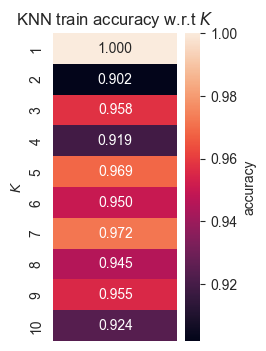

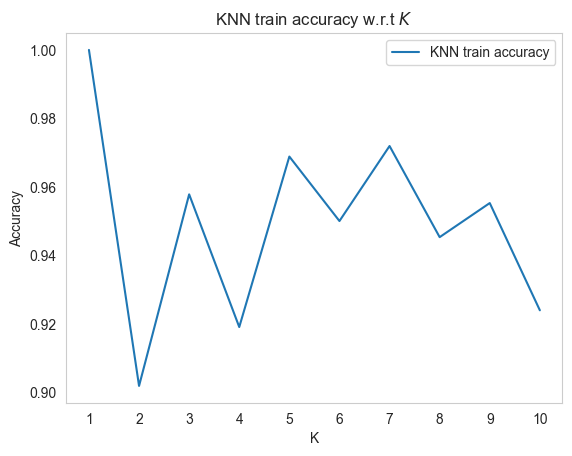

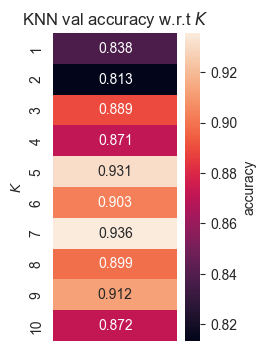

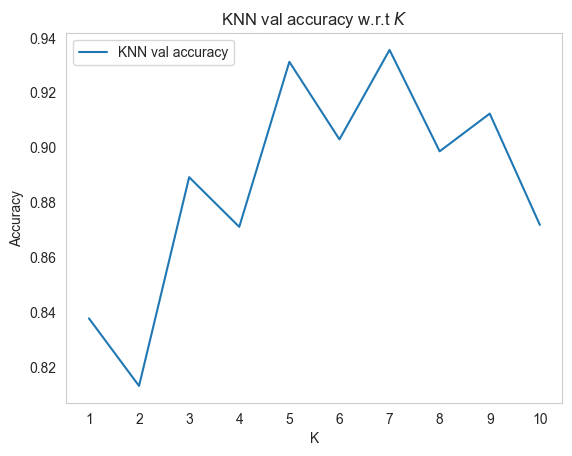

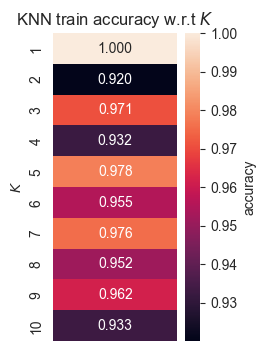

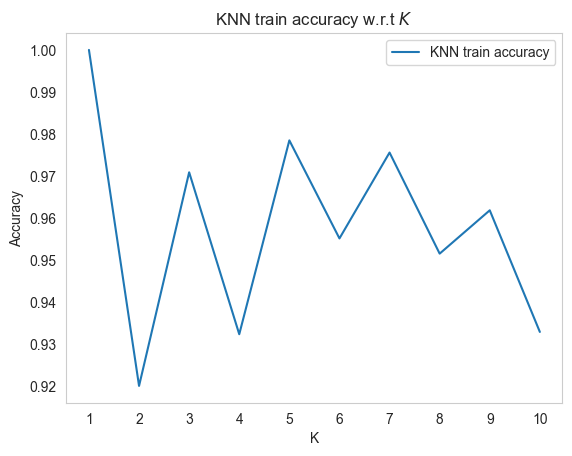

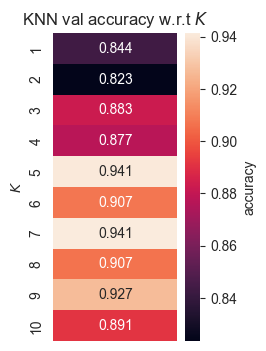

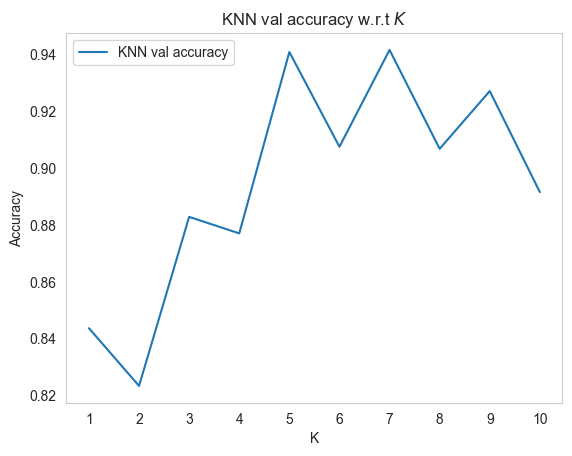

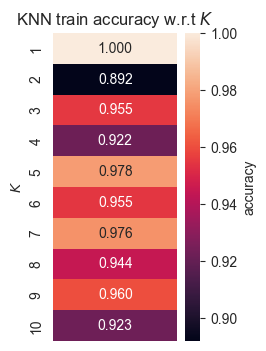

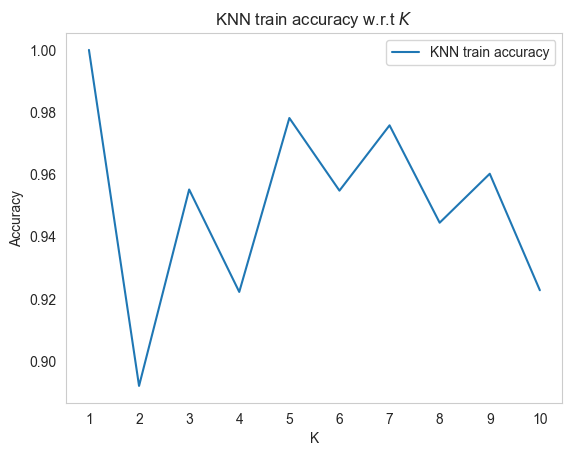

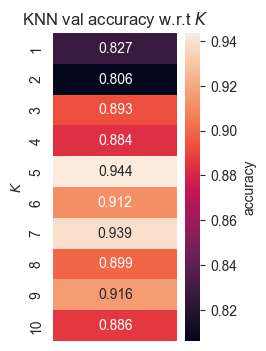

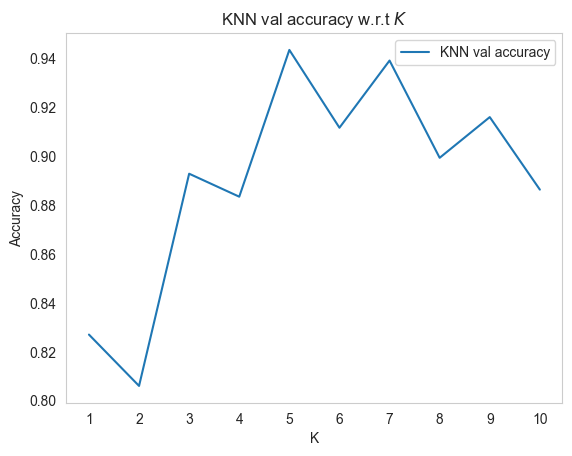

Test Accuracy Average Over 3 Trials for KNN =  0.953757225433526
Partition:  0.5


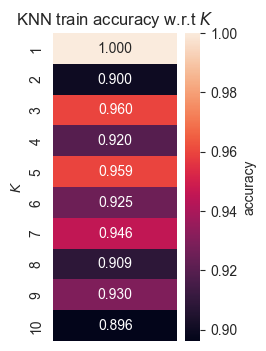

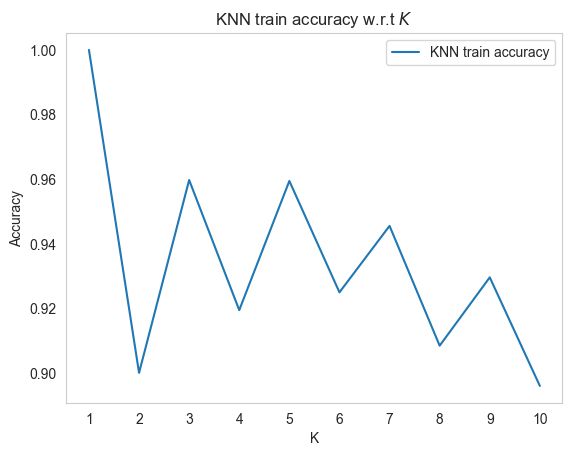

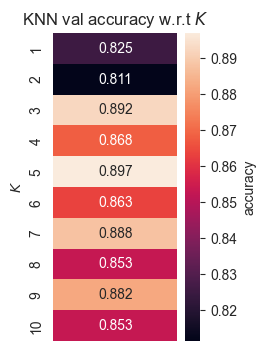

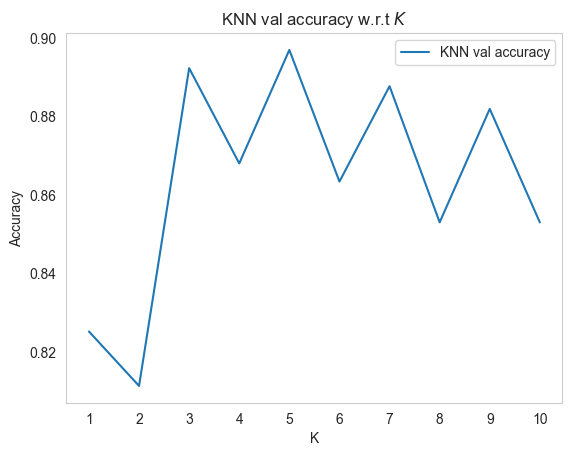

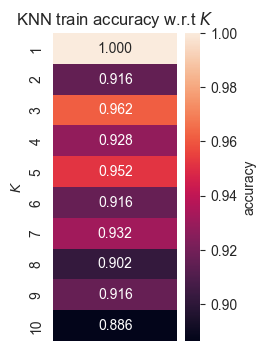

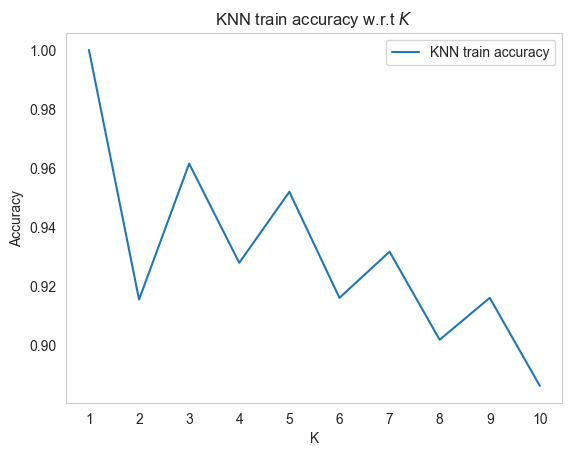

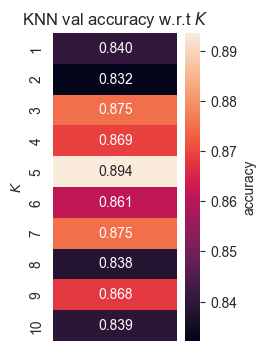

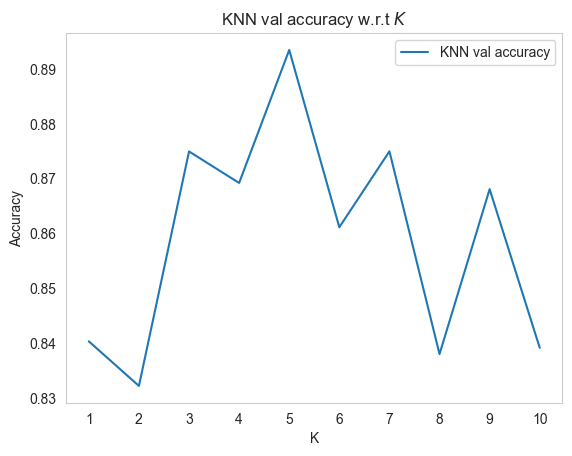

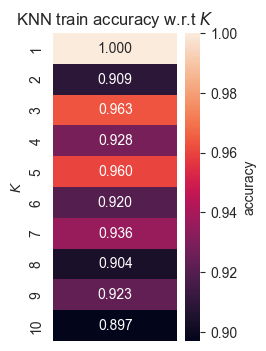

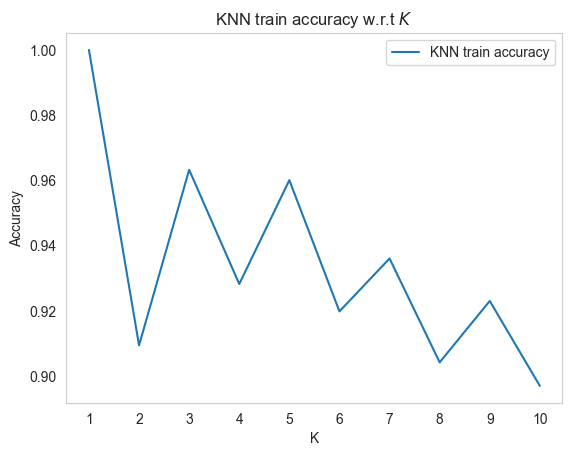

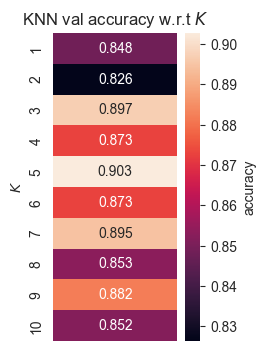

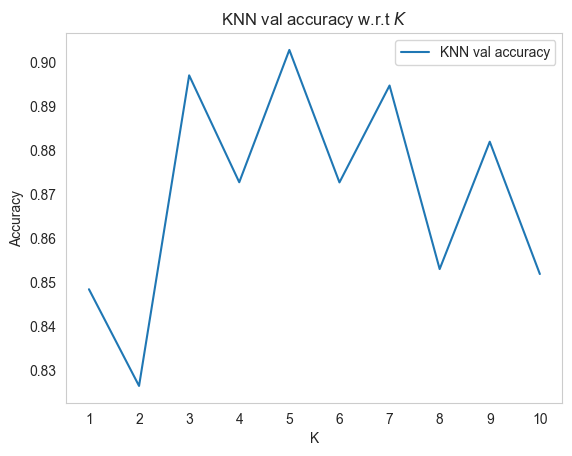

Test Accuracy Average Over 3 Trials for KNN =  0.9216820987654321
Partition:  0.2


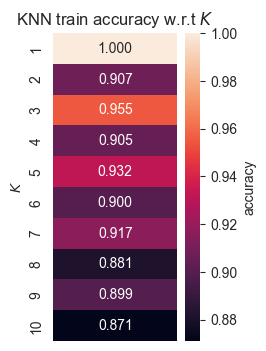

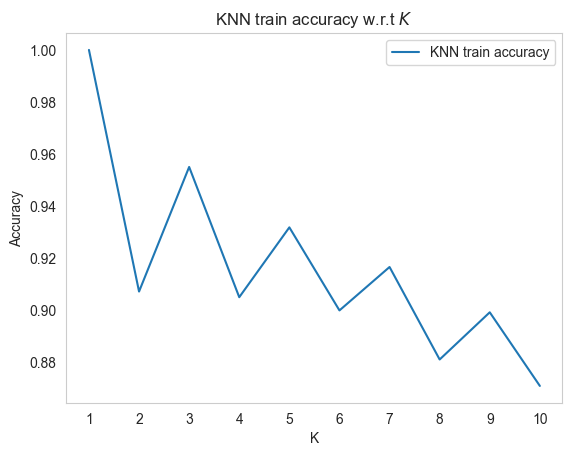

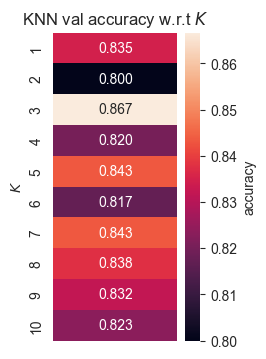

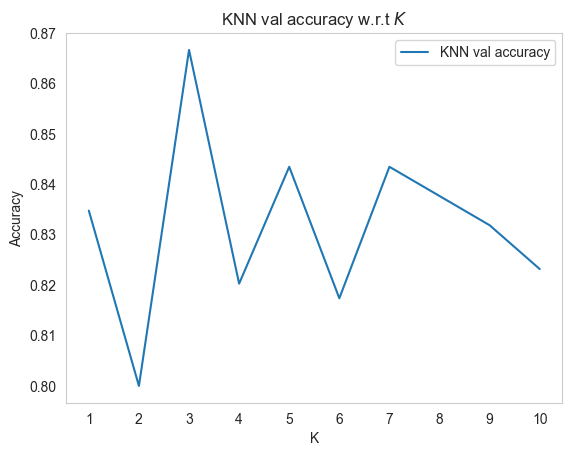

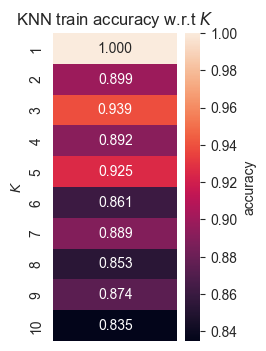

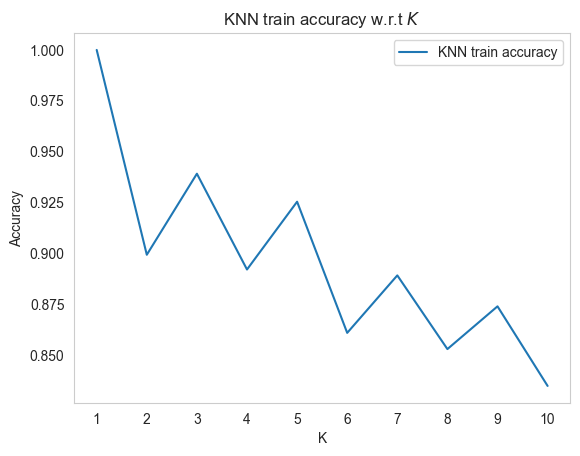

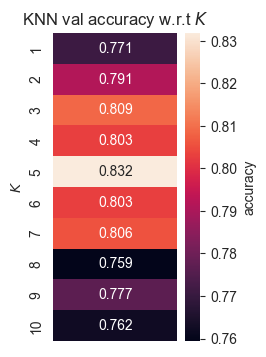

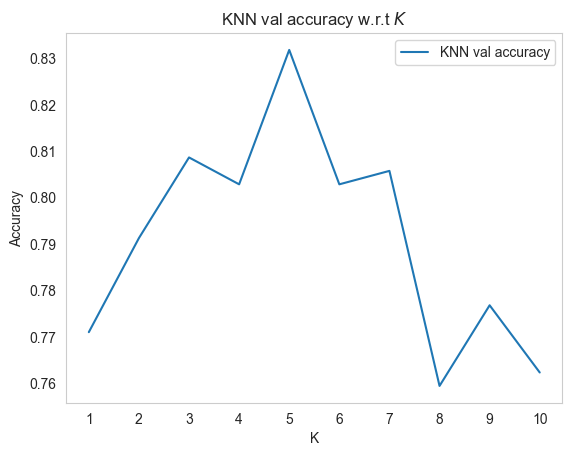

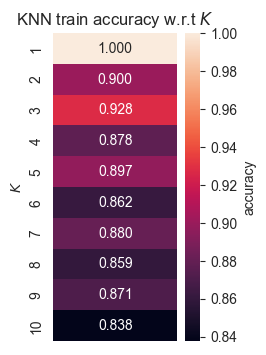

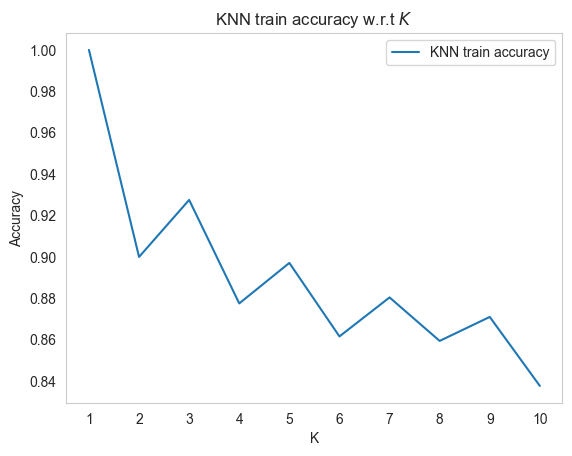

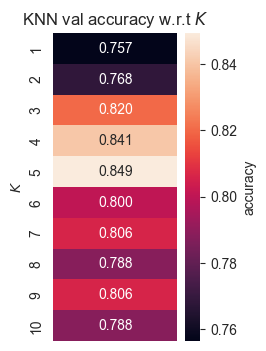

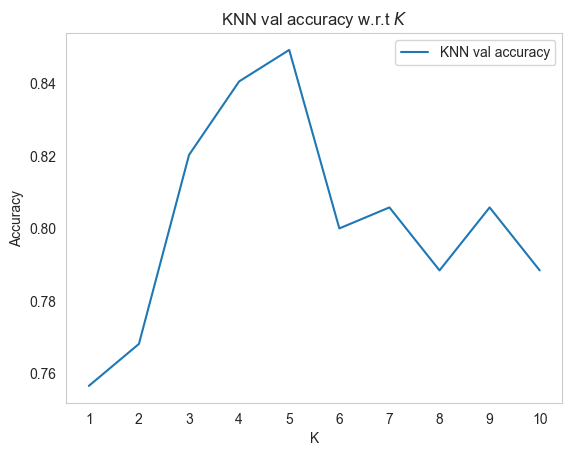

Test Accuracy Average Over 3 Trials for KNN =  0.8457459628826224


In [17]:
partition_val = [0.8, 0.5, 0.2]
for i, partition in enumerate(partition_val):
    print("Partition: ", partition)
    knn_test_acc = []

    for trial in range(3):
        np.random.shuffle(data)
        X_train = data[:int(partition*len(data)), :6]
        Y_train = data[:int(partition*len(data)), 6]
        X_test = data[int(partition*len(data)):, :6]
        Y_test = data[int(partition*len(data)):, 6]

        test_acc, best_train, c = knn_classifier()
        knn_test_acc.append(test_acc)
        
    avg_test_acc = sum(knn_test_acc)/3
    avg_test_acc_result[i, 2] = avg_test_acc
    best_train_result[i, 2] = best_train
    best_param_result[i, 2] = c
    
    print("Test Accuracy Average Over 3 Trials for KNN = ", avg_test_acc)

### 4. Results

In [18]:
print(avg_test_acc_result)

[[0.72543353 0.72061657 0.95375723]
 [0.71064815 0.71064815 0.9216821 ]
 [0.7208966  0.72258376 0.84574596]]


In [19]:
print(best_train_result)

[[0.71436377 0.72847308 0.97811198]
 [0.71874807 0.73727738 0.96007127]
 [0.73478261 0.72536232 0.89710145]]


In [20]:
print(best_param_result)

[[ 0.01  1.    5.  ]
 [ 0.1   1.    5.  ]
 [ 1.   10.    5.  ]]
